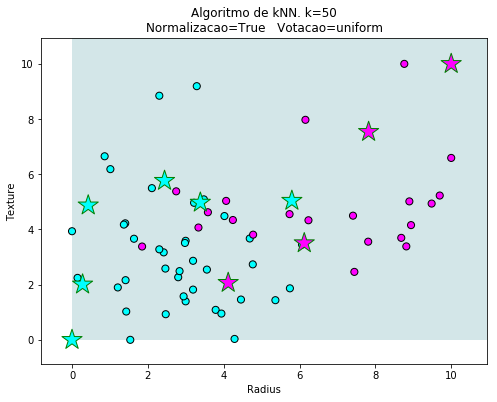

In [10]:
%matplotlib inline
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import preprocessing
import random
import sys
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
from IPython import display

class parametros_do_classificador:
    def __init__(self):
        pass

def carrega_dados_cancer_mama():
    nome_arquivo = "wdbc.csv"
    cancer_data_file = open(nome_arquivo)
    nome_atributos = [i.strip() for i in cancer_data_file.readline().split(',')]
    X = np.loadtxt(fname = cancer_data_file, usecols=range(30), delimiter = ',')

    cancer_data_file = open(nome_arquivo)
    nome_atributos = [i.strip() for i in cancer_data_file.readline().split(',')]
    Y = np.loadtxt(fname = cancer_data_file, dtype='str', usecols=[30], delimiter = ',')
    Y = np.array([0 if y=='B' else 1 for y in Y]) # substitui 'B' por 0, 'M' por 1
    
    attr1 = 0
    attr2 = 1
    ninstances_training = 60
    ninstances_testing  = 10

    nome_atributos = (nome_atributos[attr1], nome_atributos[attr2])
    
    random.seed(3)  # utiliza sempre a mesma semente aleatoria, para que experimentos sejam reprodutiveis
    selected_instances_training = list(random.sample(range(len(X)), ninstances_training))
    X_train=X[:,(attr1,attr2)]
    X_train=X_train[selected_instances_training, :]
    Y_train=Y[selected_instances_training]
    X_train[:,1] = 1.5 * X_train[:,1]  # artificialmente escala atributo para acentuar problema de normalizacao

    random.seed(11)  # utiliza sempre a mesma semente aleatoria, para que experimentos sejam reprodutiveis
    selected_instances_testing = list(random.sample(range(len(X)), ninstances_testing))
    X_test=X[:,(attr1,attr2)]
    X_test=X_test[selected_instances_testing, :]
    Y_test=Y[selected_instances_testing]
    
    return [X_train, Y_train, X_test, Y_test, nome_atributos]

def exibe_resultados(classificador, X_train, Y_train, X_test, Y_test, classificador_parametros):    
    # Exibe (1) instancias no conjunto de treino com suas classes verdadeiras
    #       (2) instancias no conjunto de teste com suas classes verdadeiras
    #       (3) a superficie de decisao do classificador; 
    #       (4) uma dada instancia de teste e seus k vizinhos mais proximos

    # Limpa a tela e inicializa figura de resultados
    display.clear_output(wait=False)
    fig = plt.figure(1, figsize=(8, 6))
    fig.clf()
    plt.title('Algoritmo de kNN. k=%d\nNormalizacao=%s   Votacao=%s' % (classificador_parametros.k_neighbors, classificador_parametros.normalizacao, classificador_parametros.metodo_de_votacao))
    
    # Exibe a superficie de decisao
    x0_min = min(X_train[:, 0].min(), X_test [:, 0].min())
    x0_max = max(X_train[:, 0].max(), X_train[:, 0].max())
    x1_min = min(X_train[:, 1].min(), X_test [:, 1].min())
    x1_max = max(X_train[:, 1].max(), X_test [:, 1].max())
    
    x_min, x_max = x0_min - 0.1*x0_min, x0_max + 0.1*x0_max
    y_min, y_max = x1_min - 0.1*x1_min, x1_max + 0.1*x1_max
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    Z = classificador.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2)

    # Exibe dados de treinamento coloridos de acordo com a sua classe verdadeira
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=50, edgecolor='k', cmap='cool')
    plt.xlabel(classificador_parametros.nome_atributos[0])
    plt.ylabel(classificador_parametros.nome_atributos[1])
    
    # Exibe dados de teste coloridos de acordo com a sua classe verdadeira
    if classificador_parametros.exibe_conjunto_de_teste:
        Y_predicted_test = classificador.predict(X_test)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=450, edgecolor='g', marker='*', cmap='cool')

    # Destaca a instancia de teste selecionada e os seus vizinhos mais proximos
    indice_da_instancia_em_destaque = 5 # pre-determinado para exemplificar a importancia de normalizacao
    if classificador_parametros.destacar_vizinhos_mais_proximos == True:
        x_teste = X_train[indice_da_instancia_em_destaque, :]
        y_teste = Y_train[indice_da_instancia_em_destaque]
        plt.scatter(x_teste[0], x_teste[1], c=y_teste, s=200, marker='x', edgecolor='r', cmap='cool')
        nbrs = NearestNeighbors(n_neighbors=classificador_parametros.k_neighbors+1, algorithm='ball_tree').fit(X_train)
        distancias, indices = nbrs.kneighbors(X_train)
        nearest_points_indices = indices[indice_da_instancia_em_destaque][1:]
        plt.scatter(X_train[nearest_points_indices, 0], X_train[nearest_points_indices, 1], c=Y_train[nearest_points_indices], marker='*', s=200, edgecolor='b', cmap='cool')

    plt.show()
    #raw_input()



#------------------------------------------------ 
# Algoritmo de k vizinhos mais proximos
def treina_classificador_de_knn(X, Y, knn_parametros):
    
    classificador_knn = KNeighborsClassifier(n_neighbors=knn_parametros.k_neighbors, 
                                             weights=knn_parametros.metodo_de_votacao)
    classificador_knn.fit(X, Y)
    return classificador_knn


#------------------------------------------------ 
knn_parametros = parametros_do_classificador()

knn_parametros.exibe_conjunto_de_teste = True          # se a visualizacao deve exibir o conjunto de teste ou nao
knn_parametros.destacar_vizinhos_mais_proximos = False  # exibe os vizinhos mais proximos de uma instancia de exemplo

knn_parametros.k_neighbors  = 50                   # numero de vizinhos
knn_parametros.normalizacao = True               # normaliza atributos para a mesma faixa de valores?
knn_parametros.metodo_de_votacao = 'uniform'      # todos k vizinhos mais proximos influenciam igualmente a votacao
# knn_parametros.metodo_de_votacao = 'distance'     # os vizinhos mais proximos tem mais influencia na votacao

[X_treino, Y_treino, X_teste, Y_teste, knn_parametros.nome_atributos] = carrega_dados_cancer_mama()
NTreino = len(X_treino)
Nteste  = len(X_teste)

if knn_parametros.normalizacao:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))
    X_treino = min_max_scaler.fit_transform(X_treino)
    X_teste  = min_max_scaler.fit_transform(X_teste)

classificador_knn = treina_classificador_de_knn(X_treino, Y_treino, knn_parametros)

exibe_resultados(classificador_knn, X_treino, Y_treino, X_teste, Y_teste, knn_parametros)
